# Minimierung der Lateness jedes Produktionsauftrags

$$
L_j = C_j - d_j
$$


- $L_j$: Lateness (Verspätung oder Frühfertigung) des Jobs $j$
- $C_j$: tatsächliche Fertigstellungszeit (Completion Time) von Job $j$
- $d_j$: Deadline bzw. geplanter Fertigstellungstermin von Job $j$

**Interpretation:**

- $L_j > 0$: Job ist **verspätet**
- $L_j = 0$: Job ist **pünktlich**
- $L_j < 0$: Job ist **zu früh** fertig

In [13]:
import pandas as pd

# Utils
import src.utils.visualization.gantt_diagram as gantt
from src.utils.initialization import jobs_jssp_init as init
from src.utils.analysis_basics import check_constraints as check
from src.utils.rolling_process.rolling_filter import *

# Solver
from src.solvers.converter import get_job_ops_dict, get_times_dict, get_schedule_dframe
from src.solvers.cp.main_solvers import solve_jssp_lateness_with_start_deviation

# Simulation
from src.simulation.ProductionRollingSimulation import ProductionSimulation

# Data access
from configs.path_manager import get_path

pd.set_option('display.min_rows', 12)
pd.set_option('display.max_rows', 16)

In [2]:
# Harte Abbruchbedingung für die Scheduler
max_time = 60*3     # 3 min

# Simulation
simulation = ProductionSimulation(sigma = 0.25)

In [3]:
basic_data_path = get_path("data", "basic")
df_jssp = pd.read_csv(basic_data_path / "jssp_final.csv")
df_jssp

,Job,Routing_ID,Operation,Machine,Processing Time
0,J25-0000,8,0,M00,76
1,J25-0000,8,1,M01,69
2,J25-0000,8,2,M03,76
3,J25-0000,8,3,M05,51
4,J25-0000,8,4,M02,85
5,J25-0000,8,5,M09,11
...,...,...,...,...,...
72494,J25-7249,4,4,M03,26
72495,J25-7249,4,5,M04,69
72496,J25-7249,4,6,M08,21


In [4]:
df_jobs_times = pd.read_csv(basic_data_path / "jobs_times_final.csv")
df_jobs_times

,Job,Routing_ID,Arrival,Ready Time,End,Job Processing Time,Deadline
0,J25-0000,8,79,1440,2704.0,597,3660
1,J25-0001,6,129,1440,2336.0,416,2338
2,J25-0002,0,198,1440,2925.0,395,3744
3,J25-0003,2,243,1440,2801.0,568,3379
4,J25-0004,3,287,1440,2697.0,655,4856
5,J25-0005,1,498,1440,2630.0,510,3106
...,...,...,...,...,...,...,...
7244,J25-7244,3,518085,518400,520251.0,655,520389
7245,J25-7245,9,518089,518400,520296.0,540,519640
7246,J25-7246,6,518116,518400,520027.0,416,520157


## Day 1
- On day 0, the first jobs (production orders) arrive, so nothing can be planned yet
- On day 1, the initial planning takes place

In [5]:
day_length = 1440

day_numb = 1
day_start = day_length*day_numb
day_end = day_start + day_length
print(f"Tag {day_numb:02d}: [{day_start}, {day_end})")

Tag 01: [1440, 2880)


In [6]:
# New and unfinished jobs
df_jobs_times_current = get_current_jobs(
    df_jobs_times, df_previous_not_started = None, ready_time=day_start
)
df_jobs_times_current

,Job,Routing_ID,Arrival,Ready Time,End,Job Processing Time,Deadline
0,J25-0000,8,79,1440,2704.0,597,3660
1,J25-0001,6,129,1440,2336.0,416,2338
2,J25-0002,0,198,1440,2925.0,395,3744
3,J25-0003,2,243,1440,2801.0,568,3379
4,J25-0004,3,287,1440,2697.0,655,4856
5,J25-0005,1,498,1440,2630.0,510,3106
6,J25-0006,9,790,1440,2905.0,540,3539
7,J25-0007,5,925,1440,2930.0,496,2929
8,J25-0008,4,988,1440,2986.0,393,3541
9,J25-0009,7,1004,1440,3045.0,539,3578


In [7]:
# current JSSP (Job Shop Scheduling Problem) basic data
df_jssp_current = filter_current_jssp(df_jssp, df_jobs_times_current, exclusion_dataframes_list = None)
df_jssp_current

,Job,Routing_ID,Operation,Machine,Processing Time
0,J25-0000,8,0,M00,76
1,J25-0000,8,1,M01,69
2,J25-0000,8,2,M03,76
3,J25-0000,8,3,M05,51
4,J25-0000,8,4,M02,85
5,J25-0000,8,5,M09,11
...,...,...,...,...,...
154,J25-0015,5,4,M08,48
155,J25-0015,5,5,M09,72
156,J25-0015,5,6,M00,47


### Scheduling Preperation

In [8]:
job_ops_dict = get_job_ops_dict(df_jssp_current)
job_ops_dict

{'J25-0000': [(0, 'M00', 76),
  (1, 'M01', 69),
  (2, 'M03', 76),
  (3, 'M05', 51),
  (4, 'M02', 85),
  (5, 'M09', 11),
  (6, 'M06', 40),
  (7, 'M07', 89),
  (8, 'M04', 26),
  (9, 'M08', 74)],
 'J25-0001': [(0, 'M01', 46),
  (1, 'M00', 37),
  (2, 'M03', 61),
  (3, 'M02', 13),
  (4, 'M06', 32),
  (5, 'M05', 21),
  (6, 'M09', 32),
  (7, 'M08', 89),
  (8, 'M07', 30),
  (9, 'M04', 55)],
 'J25-0002': [(0, 'M00', 29),
  (1, 'M01', 78),
  (2, 'M02', 9),
  (3, 'M03', 36),
  (4, 'M04', 49),
  (5, 'M05', 11),
  (6, 'M06', 62),
  (7, 'M07', 56),
  (8, 'M08', 44),
  (9, 'M09', 21)],
 'J25-0003': [(0, 'M01', 91),
  (1, 'M00', 85),
  (2, 'M03', 39),
  (3, 'M02', 74),
  (4, 'M08', 90),
  (5, 'M05', 10),
  (6, 'M07', 12),
  (7, 'M06', 89),
  (8, 'M09', 45),
  (9, 'M04', 33)],
 'J25-0004': [(0, 'M01', 81),
  (1, 'M02', 95),
  (2, 'M00', 71),
  (3, 'M04', 99),
  (4, 'M06', 9),
  (5, 'M08', 52),
  (6, 'M07', 85),
  (7, 'M03', 98),
  (8, 'M09', 22),
  (9, 'M05', 43)],
 'J25-0005': [(0, 'M00', 43),
  (1, '

In [9]:
times_dict = get_times_dict(df_jobs_times_current)
times_dict

{'J25-0000': (1440, 3660),
 'J25-0001': (1440, 2338),
 'J25-0002': (1440, 3744),
 'J25-0003': (1440, 3379),
 'J25-0004': (1440, 4856),
 'J25-0005': (1440, 3106),
 'J25-0006': (1440, 3539),
 'J25-0007': (1440, 2929),
 'J25-0008': (1440, 3541),
 'J25-0009': (1440, 3578),
 'J25-0010': (1440, 3345),
 'J25-0011': (1440, 3210),
 'J25-0012': (1440, 4385),
 'J25-0013': (1440, 2567),
 'J25-0014': (1440, 3315),
 'J25-0015': (1440, 2981)}

### Schedule

In [14]:
schedule = solve_jssp_lateness_with_start_deviation(
        job_ops=job_ops_dict,
        times_dict=times_dict,
        previous_schedule=None,
        active_ops=None,
        w_t= 5, w_e=1, w_first=1,
        main_pct=1, latest_start_buffer= 720,
        schedule_start= 1440, msg=False,
        timeLimit= 3600, gapRel= 0.0
    )

Model Information
  Number of variables       : 437
  Number of constraints     : 591
  Deviation terms (IntVars) : 0

Solver Information
  Solver status             : OPTIMAL
  Objective value           : 0.00
  Best objective bound      : 0.00
  Wall time                 : 0.04 seconds


In [15]:
df_schedule = get_schedule_dframe(schedule)
df_schedule

,Job,Operation,Machine,Start,Processing Time,End
0,J25-0000,0,M00,2343,76,2419
1,J25-0000,1,M01,2490,69,2559
2,J25-0000,2,M03,2559,76,2635
3,J25-0000,3,M05,2740,51,2791
4,J25-0000,4,M02,2791,85,2876
5,J25-0000,5,M09,2901,11,2912
...,...,...,...,...,...,...
154,J25-0015,4,M08,2041,48,2089
155,J25-0015,5,M09,2095,72,2167
156,J25-0015,6,M00,2167,47,2214


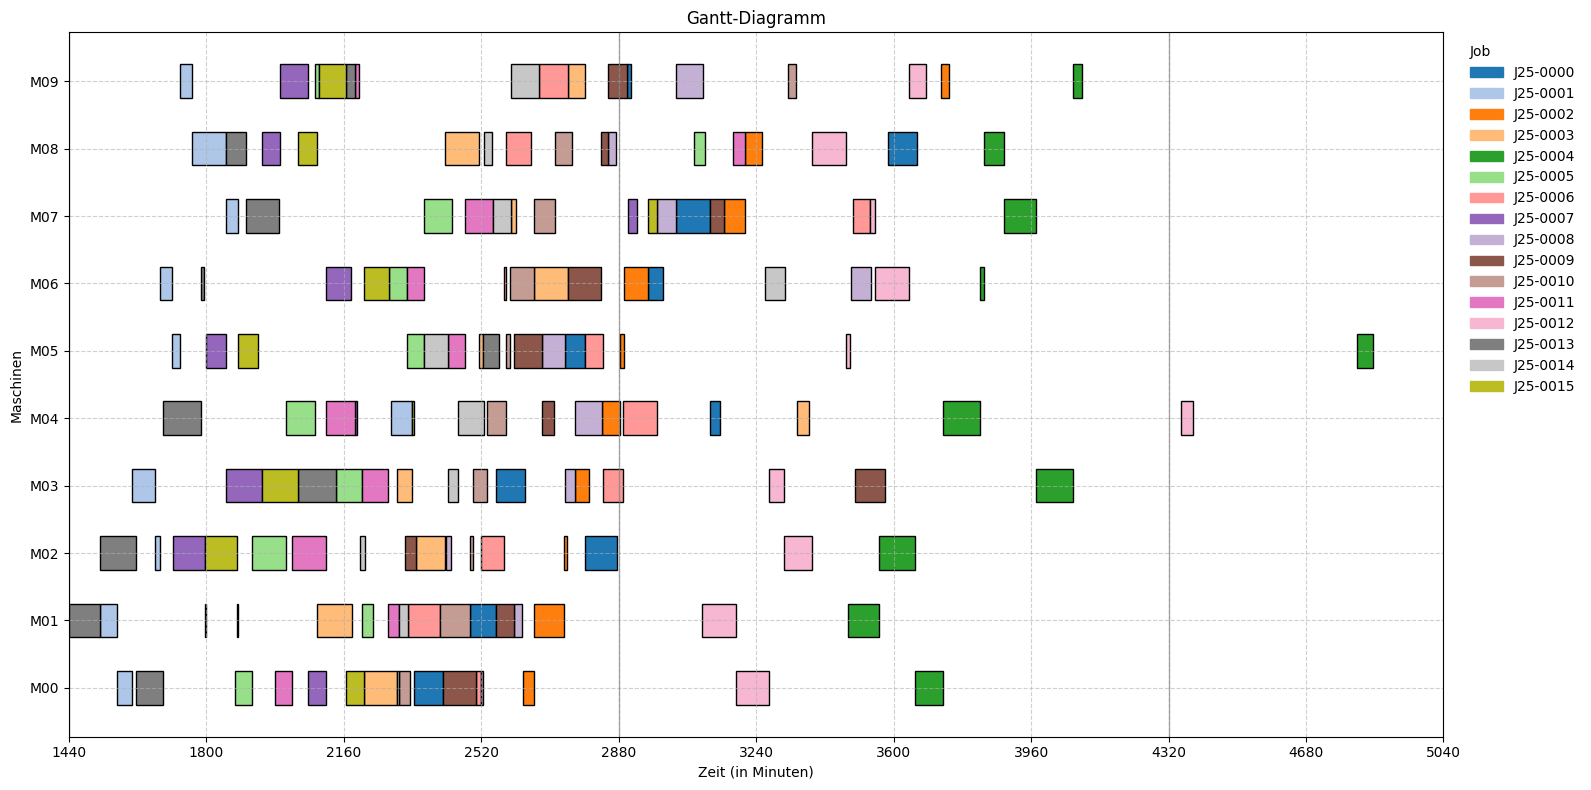

In [16]:
gantt.get_plot(df_schedule, perspective="Machine")